In [1]:
import torchvision.datasets as datasets
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Subset
import torch.nn.functional as F
from livelossplot import PlotLosses

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cuda


In [3]:
my_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST(root='./data', train=True,
                                        download=True, transform = my_transform)
indices = torch.randperm(len(trainset))[:3985]
trainset = Subset(trainset, indices)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=0)


testset = datasets.MNIST(root='./data', train=False,
                                       download=True, transform=my_transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=0)

In [4]:
class Net(torch.nn.Module):
    def __init__(self, hidden_units):
        super(Net, self).__init__()
        self.layer1 = torch.nn.Linear(28*28, hidden_units)
        self.layer2 = torch.nn.Linear(hidden_units, 10)
        
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.layer1(x))
        x = torch.sigmoid(self.layer2(x))
        return x

In [5]:
def train_and_evaluate_model(model, hidden_units, optimizer, criterion):
    train_losses = []
    test_losses = []
    test_accs = []
    model = model.to(device)
    for epoch in range(1000):
        train_loss = 0.0
        model.train()
        for data in trainloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)            
            loss = criterion(outputs.float(), F.one_hot(labels, num_classes=10).float())
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        train_losses.append(train_loss/len(trainloader))

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.float(), F.one_hot(labels, num_classes=10).float())
            test_loss += loss.item()
    test_losses.append(test_loss/len(testloader))

    return train_losses[-1], test_losses[-1]

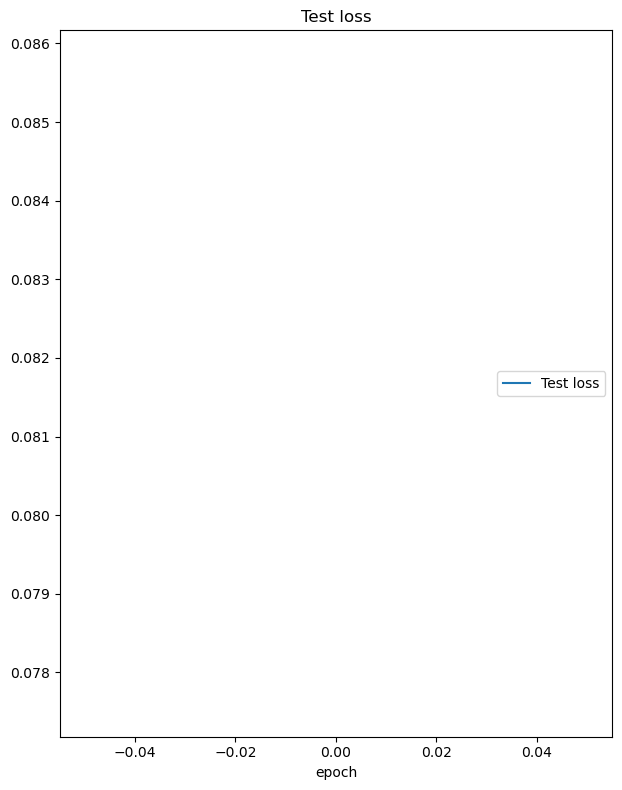

Test loss
	Test loss        	 (min:    0.082, max:    0.082, cur:    0.082)


In [ ]:
hidden_units_list = [i for i in range(1, 15)]
train_losses = []
test_losses = []
liveloss = PlotLosses()

for hidden_units in hidden_units_list:
    model = Net(hidden_units)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    criterion = torch.nn.MSELoss()
    train_loss, test_loss = train_and_evaluate_model(model, hidden_units, optimizer, criterion)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    liveloss.update({"Test loss": test_loss})
    liveloss.send()
plt.plot(hidden_units_list, train_losses, marker='o', label='train')
plt.plot(hidden_units_list, test_losses, marker='o', label='test')
plt.xlabel('Hidden units')
plt.ylabel('mse test loss')
plt.title('Double Descent Curve')
plt.legend()

plt.show()